<a href="https://colab.research.google.com/github/ShaiShmuel/deep-learning-with-python-notebooks/blob/master/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fake news detaction by title | Uriel Bender & Shai Shmuel

In [689]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import keras


Reading the Data set

In [690]:
Train_data = pd.read_csv('/content/sample_data/train.csv', error_bad_lines=False)
Test_data = pd.read_csv('/content/sample_data/test.csv', error_bad_lines=False)
Train = Train_data.copy()
Test = Test_data.copy()

In [691]:
# here we are printing first 15 lines of our train dataset
Train[0:15]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [692]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [693]:
Train.shape

(20800, 5)

In [694]:
# here we are checking if there is null values
Train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [695]:
Train = Train.dropna()

In [696]:
Train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [697]:
Train[0:10]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


We can see that we have missing values in our training set, id 6 and 8 are missing

In [698]:
news_type = pd.crosstab(Train.label, Train.title)
news_type

title,"""Allahu Akbar, the Russians are here!"": Aleppo terrorists flee Russian airstrike (VIDEO)","""Authoritarianism"": How the West demonizes strong, popular leaders","""Donald, willst du mich heiraten?"": Clinton hat Kampf ums Weiße Haus noch nicht aufgegeben","""Europe Has No Future"" Putin Slams Austria Migrant Child Rape Injustice","""Fake News"" About Trump Continues Unabated","""France First"" – Le Pen Hits Out At Islamism and Globalisation","""Hamilton"" Actor Refuses To Apologize For Political Stunt","""Just say it's the Russians"" - Joaquin Flores on RT [Video]","""Top Five Clinton Donors Are Jewish"" - How Anti-Semitic Is This Fact?","""Zu unseriös"": Auch Lothar Matthäus sagt HSV als Sportdirektor ab",#2816: Clinton Pride’s 8(a) Pig Farm Bridge – Serco Zulu Server Snuff –Soros's Patented Voter Key,#2817: Serco's Zulu Starnet Blackmail – Clinton 8(a) Pig Farm Bridge – Soros Patent Vote,#2820: Clinton 8(a) Pig Farm Servers – Boeing Bridge Of Pimps – Serco In-Flight Zulu Snuff,#BREAKING: SECOND Assassination Attempt On Trump In NV; Suspect Detained (LIVE BLOG),#BREAKING: TRUMP USHERED OFF STAGE IN NV SUSPECT DETAINED,#BoycottComedian…ROBERT DENIRO Wanted “To Punch Trump In The Face”…Supports Anti-Trump Rioters…Now Wants Americans To Support His New Movie [VIDEO],#DraftOurDaughters: Feminist Hillary Supporters Vow To Fight War With Russia For Us,#DraftOurDaughters: Pro-War Hillary Faces Backlash Over Female Draft,#GrammysSoWhite Came to Life. Will the Awards Face Its Race Problem? - The New York Times,#InNorthDakota ~~ PALESTINIANS STAND WITH THE SIOUX,#MayorsStand4All Day Touts Support for Illegal Immigrants,#MyUnintendedJoy: Americans Show Why They Choose Life Over Abortion - Breitbart,#NoDAPL Situation Critical,#NoDAPL Spills Over: Musicians Boycott Dakota Access Pipeline CEO’s Record Label & Festival,#NoDAPL: Angry Man Fires 7 Shots Into Air Near Standing Rock Water Protectors,#Podesta21: Clinton’s ‘Twisted’ Behavior ‘Smacks of Acting Above the Law’,#PodestaEmails20: WikiLeaks releases another batch from Clinton campaign chair,#ProtestPP: Nationwide Protests Against Government Funding of Planned Parenthood Underway - Breitbart,#RESIST as Marketing: ’Fearless Girl’ Statue Taking Home Awards at Cannes - Breitbart,#TrumpProtest: Communists Mobilize To Disrupt President-Elect Trump’s Inauguration,"$2,700 for Hillary Clinton at ‘Hamilton’? That Would Be Enough - The New York Times",$20 Billion in Tax Credits Fails to Increase College Attendance - The New York Times,$25 Million in Breakthrough Prizes Given in Science and Math - The New York Times,"$50,000 Reward for Facebook Killer as Manhunt Goes ’National’ - Breitbart",$6 Million Later: North Dakota Police Can’t Afford The Pipeline Protest,$7 Million in Donations to Go Directly to Orlando Kin and Survivors - The New York Times,$70 Million Awarded to Woman with Ovarian Cancer Due to Baby Powder Usage,'All About Jesus' shirt sparks school uproar,'Alt-Right' Meeting Full Video Replay: People Give Hitler Salute For Donald Trump,'D**k-Waving Berlusconi Knockoff': Late-Night Host's Nasty Trump Attack Dismantled by Steven Crowder,...,"“Man hat Angst, das Haus zu verlassen”",“Memoirs Of A Misogynist” Is A Brutal And Entertaining Look At Our Sexual Dystopia,"“Mommy am I Going To Die?” Mom Calls 911 For Paramedic, Cop Shows Up, Shoots 4 Year Old Daughter",“Mr. Wonderful te hace pensar a saco”,“My Trampoline Addiction Hell” Buster The Boxer Tells All,"“National Mood” Focus Group Reflects Angry, Divided America",“Not A ‘Real’ Union”: Emails Show Clinton Campaign Attacks On Nurses,“Nothing Good Can Come of This Election”–and That’s Good,“Organic” Food From China Found To Be Highly Contaminated,“People Power” Versus Manipulation of the Masses,“Regime Change”? South Africa Targeted by Western Destabilization Efforts? | Global Research,“Rigged To Deny Trump”: Are They Stealing These States to Block Electoral Path to 270?,“Rigged To Deny Trump”: Looks Like Elite Trying to Steal These

In [699]:
Train.groupby('label').count()

,id,title,author,text
label,,,,
0,10361,10361,10361,10361
1,7924,7924,7924,7924


We want to check if all of our titels and texts have a reasonable length

In [700]:
lengthttl,lengthtxt = [],[]
#Title
[lengthttl.append(len(str(title))) for title in Train['title']]
Train['title-length'] = lengthttl
#Same for the text
[lengthtxt.append(len(str(text))) for text in Train['text']]
Train['text-length'] = lengthtxt
Train.head()

,id,title,author,text,label,title-length,text-length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938


In [701]:
min(Train['title-length']), max(Train['title-length']), round(sum(Train['title-length'])/len(Train['title-length']))

(3, 456, 75)

In [702]:
def get_outliers(df, series):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)

  if q1*q3 == 0:
    iqr = abs(2*(q1+q3))
    toprange = iqr
    botrange = -toprange
  else:
    iqr = q3-q1
    toprange = q3 + iqr * 1.5
    botrange = q1 - iqr * 1.5

  outliers_top=df[series > toprange]
  outliers_bot= df[series < botrange]
  outliers = pd.concat([outliers_bot, outliers_top], axis=0)

  return (botrange, toprange, outliers)

In [703]:
botrange, toprange, outliers = get_outliers(Train, Train['title-length'])
print(toprange)
print(botrange)
outliers

128.5
20.5


,id,title,author,text,label,title-length,text-length
86,86,Poison,Heather Callaghan,By Dr. Mark Sircus Everyone knows that there a...,1,6,202
156,156,The Battle at UNESCO,Ari Lieberman,"The Muslim Bloc may have won the battle, but d...",1,20,7772
248,248,The Left’s Vision,Thomas Sowell,"By Thomas Sowell November 1, 2016 \nThe politi...",1,17,4391
257,257,Newsticker (974),noreply@blogger.com (Der Postillon),+++ Hände weg vom Alkohol: Schreiner rührt nac...,1,16,772
347,347,LesserOfTwoEvilism,Anonymous,2016 presidential campaign by Matt Sedillo \nH...,1,18,8573
...,...,...,...,...,...,...,...
20223,20223,Comment on Understanding Misleading Food Label...,Understanding Misleading Food Labels: An Infog...,Share on Facebook Share on Twitter “Let food b...,1,277,3675
20277,20277,"Like a good little sharia-compliant female, Pr...",BareNakedIslam,BNI Store Nov 6 2016 Like a good little sharia...,1,165,830
20324,20324,THE END GAME closes in on the Clintons as the ...,Dave Hodges,THE END GAME closes in on the Clintons as the ...,1,188,10103
20513,20513,SAID IN SPANISH: A Mexican Governor Meddles In...,Allan Wall,,1,156,1


In [704]:
fig = go.Figure()
fig.add_trace(go.Box(name='Title length', y=Train['title-length'], boxmean='sd'))

fig.update_traces(
    marker=dict(
        color='rgb(8,81,156)',
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2)),
    line_color='rgb(8,81,156)'
)
fig.show()

In [705]:
Train.shape

(18285, 7)

In [706]:
len(Train[Train['title-length'] < 20])


158

In [707]:
len(Train[Train['title-length'] > 128])


214

Same process with our text length

In [708]:
botrange, toprange, outliers = get_outliers(Train, Train['text-length'])
print(toprange)
print(botrange)
outliers

13586.5
-5217.5


,id,title,author,text,label,title-length,text-length
14,14,"Re: Yes, There Are Paid Government Trolls On S...",AnotherAnnie,"Yes, There Are Paid Government Trolls On Socia...",1,85,34204
29,29,How Hillary Clinton Became a Hawk - The New Yo...,Mark Landler,Hillary Clinton sat in the hideaway study off ...,0,54,38806
36,36,Re: Why We Are Still In ‘The Danger Zone’ Unti...,greanfinisher .,Why We Are Still In ‘The Danger Zone’ Until Ja...,1,66,20807
37,37,Open Thread (NOT U.S. Election) 2016-39,b,Open Thread (NOT U.S. Election) 2016-39 \nNews...,1,39,18950
71,71,Treason! NYT vows 'rededication' to reporting!,Ivan the Stakhanovets,"In Hillary's America, email server scrubs you ...",1,46,27696
...,...,...,...,...,...,...,...
20658,20658,Comment on 5 Corporations Own The U.S. Media –...,You’re Being Fooled: The Problem With ‘Alterna...,"From the day we are born into this world, we...",1,205,24954
20662,20662,The Truth U.S. Government Does NOT Want You To...,Dikran Arakelian (noreply@blogger.com),Share on Facebook The people of the world shou...,1,74,14247
20742,20742,It Begins! Ten Kushner Scandals: Media Ramp Up...,Tony Lee,If Jared Kushner did not realize that the esta...,0,102,18178
20744,20744,The Battleship Debate,Michael Shrimpton,"By Michael Shrimpton on October 30, 2016 Some ...",1,21,18004


In [709]:
fig = go.Figure()
fig.add_trace(go.Box(name='Text length', y=Train['text-length'], boxmean='sd'))

fig.update_traces(
    marker=dict(
        color='rgb(8,81,156)',
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2)),
    line_color='rgb(8,81,156)'
)
fig.show()

In [710]:
len(Train[Train['text-length'] < 128])


235

We would want to more accurate data, therefore, wi will drop data with too long/short titles, and short(less then 128 chars) texts

In [711]:
Train.shape

(18285, 7)

In [712]:
Train.drop(Train[Train['title-length'] > 128].index, inplace = True)
Train.drop(Train[Train['title-length'] < 20].index, inplace = True)
Train.drop(Train[Train['text-length'] < 128].index, inplace = True)
Train.drop(Train[Train['text-length'] > 10000].index, inplace = True)


In [713]:
Train.shape

(16453, 7)

Let's check that all of our relevent data is written in English, we will check the ascii value of each char, if the value is grather or equal to 128 we will the value as non English

In [714]:
def isEnglish(s):
  return all(ord(c) < 128 for c in s)
print(isEnglish("is English?"))


True


In [715]:
isEnglishttl = []
#Mark all non English titles
[isEnglishttl.append(isEnglish(str(title))) for title in Train['title']]
Train['title-English'] = isEnglishttl
#Count non English titles
len(Train[Train['title-English'] == False])


6645

In [716]:
Train[:15]

,id,title,author,text,label,title-length,text-length,title-English
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930,False
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160,True
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692,True
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237,True
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938,True
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,124,1192,True
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,87,4923,False
10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0,96,9400,False
11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0,58,3132,True
12,12,Russian Researchers Discover Secret Nazi Milit...,Amando Flavio,The mystery surrounding The Third Reich and Na...,1,95,2854,False


In [717]:
Train.drop(Train[Train['title-English'] == False].index, inplace = True)
Train.shape


(9808, 8)

In [718]:
max_features = 10000

## Tokenizing the text - converting the words, letters into counts or numbers. 


In [719]:
# We dont need to explicitly remove the punctuations. we have an inbuilt option in Tokenizer for this purpose
# importing neural network libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


tokenizer = Tokenizer(num_words = max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts  = Train['title'])
X = tokenizer.texts_to_sequences(texts  = Train['title'])

In [720]:
# now applying padding to make them even shaped.
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

In [721]:
print(X.shape)
y = Train['label'].values
print(y.shape)

(9808, 10000)
(9808,)


In [722]:
# splitting the data training data for training and validation.
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [723]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(X_train)
# Our vectorized test data
x_test = vectorize_sequences(X_test)

In [724]:
x_train[0]


array([1., 1., 1., ..., 0., 0., 0.])

In [725]:
# Our vectorized labels
y_train = np.asarray(Y_train).astype('float32')
y_test = np.asarray(Y_test).astype('float32')

Keras implementation

In [726]:

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Configure our model with the rmsprop optimizer and the binary_crossentropy loss function

In [727]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


We are passing our optimizer, loss function and metrics as strings

In [728]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [729]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### Validating our approach
we will create a "validation set" by setting apart 3,000 samples from the original training data

In [730]:
x_val = x_train[:3000]
partial_x_train = x_train[3000:]

y_val = y_train[:3000]
partial_y_train = y_train[3000:]

We will now train our model for 20 epochs

In [731]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
10/10 [==============================] - 0s 48ms/step - loss: 0.6725 - binary_accuracy: 0.7716 - val_loss: 0.6415 - val_binary_accuracy: 0.8853
Epoch 2/20
10/10 [==============================] - 0s 29ms/step - loss: 0.6065 - binary_accuracy: 0.9329 - val_loss: 0.5857 - val_binary_accuracy: 0.8970
Epoch 3/20
10/10 [==============================] - 0s 29ms/step - loss: 0.5370 - binary_accuracy: 0.9449 - val_loss: 0.5304 - val_binary_accuracy: 0.9033
Epoch 4/20
10/10 [==============================] - 0s 31ms/step - loss: 0.4691 - binary_accuracy: 0.9515 - val_loss: 0.4779 - val_binary_accuracy: 0.9090
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 0.4050 - binary_accuracy: 0.9602 - val_loss: 0.4287 - val_binary_accuracy: 0.9147
Epoch 6/20
10/10 [==============================] - 0s 29ms/step - loss: 0.3445 - binary_accuracy: 0.9680 - val_loss: 0.3830 - val_binary_accuracy: 0.9183
Epoch 7/20
10/10 [==============================] - 0s 32ms/step - los

In [732]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

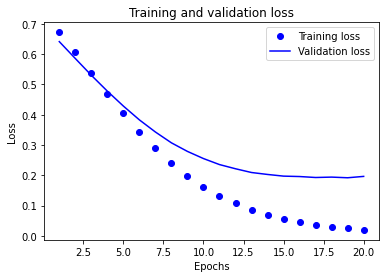

In [733]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

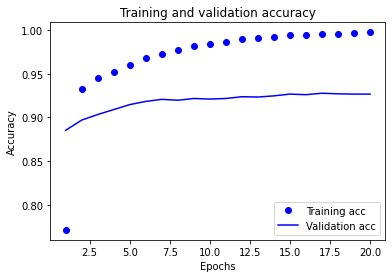

In [734]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Let's train a new network from scratch for four epochs, then evaluate it on our test data:



In [735]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
16/16 [==============================] - 0s 26ms/step - loss: 0.6318 - accuracy: 0.7377
Epoch 2/4
16/16 [==============================] - 0s 24ms/step - loss: 0.4795 - accuracy: 0.9194
Epoch 3/4
16/16 [==============================] - 0s 24ms/step - loss: 0.3620 - accuracy: 0.9509
Epoch 4/4
62/62 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.9241


In [736]:
results


[0.28095632791519165, 0.9240570664405823]

In [737]:
model.predict(x_test)


array([[0.06238341],
       [0.10851178],
       [0.82760763],
       ...,
       [0.8679755 ],
       [0.6152399 ],
       [0.08238831]], dtype=float32)

In [738]:
len(x_train)

7846